In [10]:
#!pip install -U datascienv

In [37]:
import ee
import folium
import geemap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Authenticate to the Earth Engine servers
# Initialize the API

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjyuwXd387byOT-VrBga3J9Yi8dgELglIdkHufw4TfK4EP_nZ7GxAE

Successfully saved authorization token.


## Classification with Random Forest

The `Classifier` package handles supervised classification in Earth Engine and the general workflow for classification is:

1. Collect training data. Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.

2. Instantiate a classifier. Set its parameters if necessary.
3. Train the classifier using the training data.
4. Classify an image or feature collection.
5. Estimate classification error with independent test data.

- The training data is a `FeatureCollection` with a property storing the class label and properties storing predictor variables.
- Class labels should be consecutive, integers starting from 0. If necessary, use `remap()` to convert class values to consecutive integers. The predictors should be numeric.
- Training and/or testing data can come from a variety of sources. 
- To collect training data interactively in Earth Engine, you can use the geometry drawing tools (see the [Code Editor section](https://developers.google.com/earth-engine/playground)). 
- Alternatively, you can import predefined training data from an Earth Engine table asset or a Fusion Table (see the [Importing section](https://developers.google.com/earth-engine/importing) for details). 
- Get a classifier from one of the constructors in `ee.Classifier`. Train the classifier using `classifier.train()`. Classify an `Image` or `FeatureCollection` using `classify()`.

We use random forest classifier with 10 trees to downscale MODIS data to Landsat resolution. The `sample()` method generates two random samples from the MODIS data: one for training and one for test. The training sample is used to train the classifier. You can get resubstitution accuracy on the training data from `classifier.confusionMatrix()`. To get test accuracy, classify the test data. This adds a `classification` property to the test `FeatureCollection`. Call `errorMatrix()` on the classified `FeatureCollection` to get a confusion matrix representing test (expected) accuracy.

In [12]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Point",
        "coordinates": [
          36.76025390625,
          -13.304102866767076
        ]
      }
    }
  ]
}

In [53]:
# Add map
map1 = geemap.Map()

# Define a region of interest as a point.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Point(coords)

# Chosen bands 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


# Load Landsat 8 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select the bands 
landsat = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA")\
                   .filterDate('2011-01-01', '2021-09-30')\
                   .filterBounds(AOI)\
                   .sort('CLOUD_COVER')\
                   .first()\
                   .select(bands))

# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Program) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn(seed=0)

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
  'aec3d4', # water
  '152106', '225129', '369b47', '30eb5b', '387242', # forest
  '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
  '111149', # wetlands
  'cdb33b', # croplands
  'cc0013', # urban
  '33280d', # crop mosaic
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]

# # Display the input and the classification.
# Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) 
# classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
# center = [-12.57, 35.52]
# Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

# Display the input and the classification.
map1.centerObject(AOI, 8)
map1.addLayer(Input, {'bands': ['B5', 'B4', 'B2'], 'max': 0.4}, 'landsat') # L8 B5=NIR B4=Red B2=Blue
map1.addLayer(classified, {'palette': igbpPalette, 'min': 0, 'max': 17}, 'classification')


# Add legend
legend_keys = ['water', 'forest', 'forest', 'forest', 'forest', 'forest', 'shrub, grass', 
               'shrub, grass', 'shrub, grass', 'shrub , grass', 'shrub , grass', 'wetlands', 
               'croplands', 'urban', 'crop mosaic', 'snow and ice', 'barren', 'tundra']

legend_colors = ['aec3d4', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
                 'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
                 '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
# legend_colors = ['blue', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'gray', 
#                  'gray', 'gray', 'gray', 'gray', 'maroon', 'green', 'yellow',
#                  'black', 'chocolate', 'cyan', 'darkorange']


# Classify the input imagery.
classified = classified.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

map1.addLayer(classified, {'min': 0, 'max': 17, 'palette': legend_colors}, 'Labelled clusters')
map1.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

The number of total images is : 4859

The number of images for training Partition is : 3494

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 27, 0, 0, 2, 6, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2013, 35, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 133, 1218, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 35]]

Training accuracy is : 94.42 %

The number of images for test Partition is : 1365

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0

The accuracy estimated from training data is an overestimate because the random forest is "fit" to the training data. The expected accuracy on unknown data is a too lower, as indicated by the estimate from the test data.

This test accuracy is bad for Landsat 8: **overfitting**

In [44]:
map1

Map(center=[-13.304102866767076, 36.76025390625], controls=(WidgetControl(options=['position', 'transparent_bg…

In [6]:
print(type(trainAccuracy.getInfo()))
print(cloudScore.getInfo()['bands'])

<class 'list'>
[{'id': 'cloud', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 100}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32637', 'crs_transform': [30, 0, 243585, 0, -30, -1323285]}]


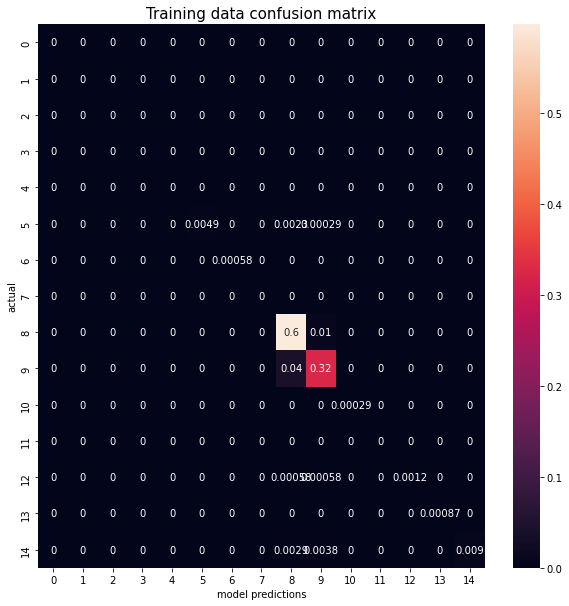

In [17]:
trainCM_L8 = trainConfusionMat/trainingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM_L8, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

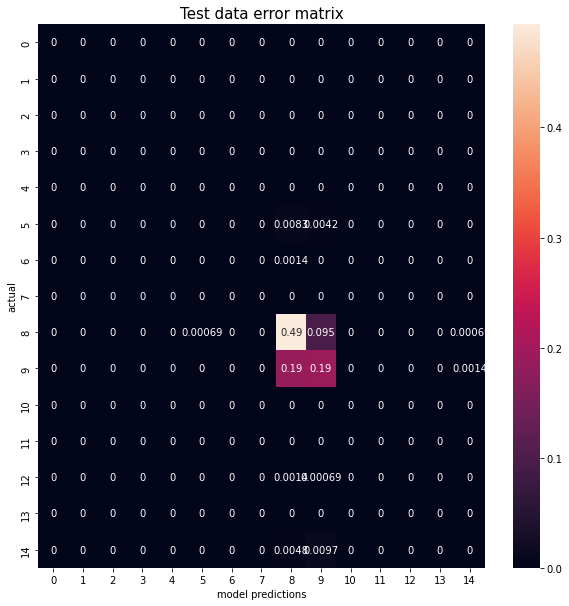

In [18]:
testEM_L8 = testErrorMat/testingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM_L8, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);

#### Let's add the number of trees

In [52]:
# Add map
map2 = geemap.Map()

# Define a region of interest as a point.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Point(coords)

# Chosen bands 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select the bands
landsat = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA")\
                   .filterDate('2011-01-01', '2021-09-30')\
                   .filterBounds(AOI)\
                   .sort('CLOUD_COVER')\
                   .first()\
                   .select(bands))

# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
  'aec3d4', # water
  '152106', '225129', '369b47', '30eb5b', '387242', # forest
  '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
  '111149', # wetlands
  'cdb33b', # croplands
  'cc0013', # urban
  '33280d', # crop mosaic
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]

# # Display the input and the classification.
# Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) 
# classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
# center = [-12.57, 35.52]
# Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

# Display the input and the classification.
map2.centerObject(AOI, 8)
map2.addLayer(Input, {'bands': ['B5', 'B4', 'B2'], 'max': 0.4}, 'landsat') # L8 B5=NIR B4=Red B2=Blue
map2.addLayer(classified, {'palette': igbpPalette, 'min': 0, 'max': 17}, 'classification')


# Add legend
legend_keys = ['water', 'forest', 'forest', 'forest', 'forest', 'forest', 'shrub, grass', 
               'shrub, grass', 'shrub, grass', 'shrub , grass', 'shrub , grass', 'wetlands', 
               'croplands', 'urban', 'crop mosaic', 'snow and ice', 'barren', 'tundra']

legend_colors = ['aec3d4', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
                 'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
                 '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
# legend_colors = ['blue', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'gray', 
#                  'gray', 'gray', 'gray', 'gray', 'maroon', 'green', 'yellow',
#                  'black', 'chocolate', 'cyan', 'darkorange']


# Classify the input imagery.
classified = classified.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

map2.addLayer(classified, {'min': 0, 'max': 17, 'palette': legend_colors}, 'Labelled clusters')
map2.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

The number of total images is : 4859

The number of images for training Partition is : 3494

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 29, 0, 0, 2, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2035, 13, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 69, 1282, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 39]]

Training accuracy is : 97.22 %

The number of images for test Partition is : 1365

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0,

We still in **overfitting** situation.

In [20]:
map2

Map(center=[-13.304102866767076, 36.76025390625], controls=(WidgetControl(options=['position', 'transparent_bg…

In [54]:
# Add map
map3 = geemap.Map()

# Define a region of interest as a point.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Point(coords)

# Chosen bands 
bands = [ 'B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select the bands
landsat = ee.Image(ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')\
                    .filterDate('2011-01-01', '2021-09-30')\
                    .filterBounds(AOI)\
                    .sort('CLOUD_COVER')\
                    .first()\
                    .select(bands))


# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn(seed=0)

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
  'aec3d4', # water
  '152106', '225129', '369b47', '30eb5b', '387242', # forest
  '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
  '111149', # wetlands
  'cdb33b', # croplands
  'cc0013', # urban
  '33280d', # crop mosaic
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]

# # Display the input and the classification.
# Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) 
# classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
# center = [-12.57, 35.52]
# Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

# Display the input and the classification.
map3.centerObject(AOI, 8)
map3.addLayer(Input, {'bands': ['B4', 'B3', 'B1'], 'max': 0.4}, 'landsat') # L5 B4=NIR B3=Red B1=Blue
map3.addLayer(classified, {'palette': igbpPalette, 'min': 0, 'max': 17}, 'classification')


# Add legend
legend_keys = ['water', 'forest', 'forest', 'forest', 'forest', 'forest', 'shrub, grass', 
               'shrub, grass', 'shrub, grass', 'shrub , grass', 'shrub , grass', 'wetlands', 
               'croplands', 'urban', 'crop mosaic', 'snow and ice', 'barren', 'tundra']

legend_colors = ['aec3d4', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
                 'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
                 '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
# legend_colors = ['blue', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'gray', 
#                  'gray', 'gray', 'gray', 'gray', 'maroon', 'green', 'yellow',
#                  'black', 'chocolate', 'cyan', 'darkorange']


# Classify the input imagery.
classified = classified.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

map3.addLayer(classified, {'min': 0, 'max': 17, 'palette': legend_colors}, 'Labelled clusters')
map3.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
map3

The number of total images is : 4587

The number of images for training Partition is : 3249

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 19, 0, 0, 39, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3142, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 27, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 1]]

Training accuracy is : 97.54 %

The number of images for test Partition is : 1338

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

Map(center=[-13.304102866767076, 36.76025390625], controls=(WidgetControl(options=['position', 'transparent_bg…

The accuracy estimated from training data is an overestimate because the random forest is “fit” to the training data. The expected accuracy on unknown data is better, as indicated by the estimate from the test data.

In [22]:
map3

Map(center=[-13.304102866767076, 36.76025390625], controls=(WidgetControl(options=['position', 'transparent_bg…

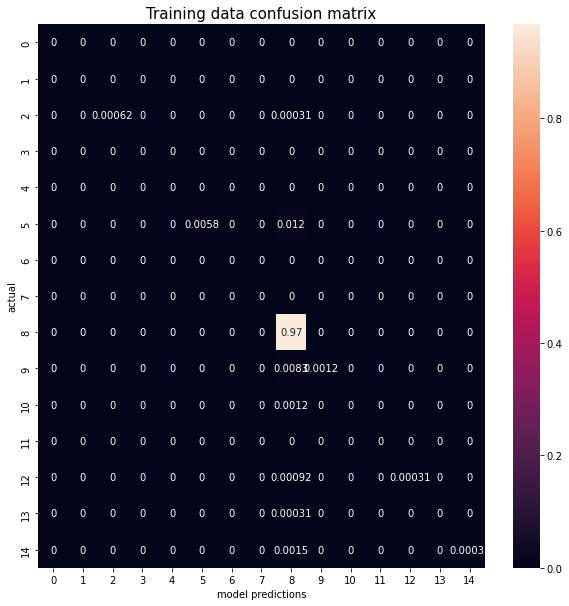

In [55]:
trainCM_L5 = trainConfusionMat/trainingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM_L5, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

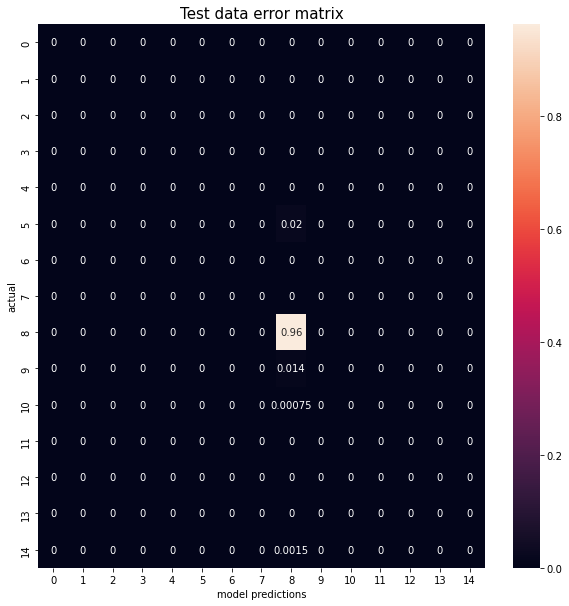

In [56]:
testEM_L5 = testErrorMat/testingPartition.size().getInfo()

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM_L5, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);

#### Let's add the number of trees

In [57]:
# Add map
map4 = geemap.Map()

# Define a region of interest as a point.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Point(coords)

# Chosen bands
bands = [ 'B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select the bands
landsat = ee.Image(ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')\
                    .filterDate('2011-01-01', '2021-09-30')\
                    .filterBounds(AOI)\
                    .sort('CLOUD_COVER')\
                    .first()\
                    .select(bands))


# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(90)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')


# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn(seed=0)

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# Make a Random Forest classifier and train it.
trainedclassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Classify the input imagery.
classified = Input.classify(trainedclassifier)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
  'aec3d4', # water
  '152106', '225129', '369b47', '30eb5b', '387242', # forest
  '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
  '111149', # wetlands
  'cdb33b', # croplands
  'cc0013', # urban
  '33280d', # crop mosaic
  'd7cdcc', # snow and ice
  'f7e084', # barren
  '6f6f6f'  # tundra
]

# # Display the input and the classification.
# Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) 
# classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
# center = [-12.57, 35.52]
# Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

# Display the input and the classification.
map4.centerObject(AOI, 8)
map4.addLayer(Input, {'bands': ['B4', 'B3', 'B1'], 'max': 0.4}, 'landsat') # L5 B4=NIR B3=Red B1=Blue
map4.addLayer(classified, {'palette': igbpPalette, 'min': 0, 'max': 17}, 'classification')


# Add legend
legend_keys = ['water', 'forest', 'forest', 'forest', 'forest', 'forest', 'shrub, grass', 
               'shrub, grass', 'shrub, grass', 'shrub , grass', 'shrub , grass', 'wetlands', 
               'croplands', 'urban', 'crop mosaic', 'snow and ice', 'barren', 'tundra']

legend_colors = ['aec3d4', '152106', '225129', '369b47', '30eb5b', '387242', '6a2325', 
                 'c3aa69', 'b76031', 'd9903d', '91af40', '111149', 'cdb33b', 'cc0013',
                 '33280d', 'd7cdcc', 'f7e084', '6f6f6f']
# legend_colors = ['blue', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'gray', 
#                  'gray', 'gray', 'gray', 'gray', 'maroon', 'green', 'yellow',
#                  'black', 'chocolate', 'cyan', 'darkorange']


# Classify the input imagery.
classified = classified.remap([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

map4.addLayer(classified, {'min': 0, 'max': 17, 'palette': legend_colors}, 'Labelled clusters')
map4.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')

The number of total images is : 4587

The number of images for training Partition is : 3249

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 15, 0, 0, 43, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3142, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 27, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2]]

Training accuracy is : 97.57 %

The number of images for test Partition is : 1338

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

In [58]:
map4

Map(center=[-13.304102866767076, 36.76025390625], controls=(WidgetControl(options=['position', 'transparent_bg…

In [18]:
#modis.getInfo()

In [19]:
type(modis.getInfo())

dict

In [20]:
len(modis.getInfo())

5

In [21]:
modis.getInfo()['bands'][0]['dimensions']

[86400, 43200]

In [22]:
modis.getInfo()['bands']

[{'id': 'Land_Cover_Type_1',
  'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255},
  'dimensions': [86400, 43200],
  'crs': 'SR-ORG:6974',
  'crs_transform': [463.3127165279165,
   0,
   -20015109.353988,
   0,
   -463.3127165274999,
   10007554.676994]}]

In [23]:
type(training.getInfo())

dict

In [24]:
#training.getInfo()